::::
:::{thebe-button}
:::
::::

# Find objects

Find bubble size using two different approaches.


In [5]:
from boilercv_docs.nbs import init

paths = init()

from devtools import pprint
from geopandas import GeoDataFrame, points_from_xy
from numpy import pi, sqrt
from pandas import DataFrame, IndexSlice, NamedAgg
from pipeline.boilercv_pipeline.stages.e230920_find_objects import (
    E230920FindObjects as Params,
)
from seaborn import scatterplot
from shapely import LinearRing, Polygon

from boilercv.images import scale_bool
from boilercv_docs.nbs import HIDE, nowarn, set_display_options
from boilercv_docs.stages.e230920_find_objects import (
    E230920FindObjects as DefaultParams,
)
from boilercv_pipeline.sets import get_contours_df, get_dataset2
from boilercv_pipeline.stages.common.e230920 import GBC, bounded_ax, get_time
from boilercv_pipeline.stages.common.e230920.types import DfNbOuts

PARAMS = DefaultParams()


COMPARE_WITH_TRACKPY = True
"""Whether to get objects using the Trackpy approach."""
GUESS_DIAMETER = 21
"""Guess diameter for the Trackpy approach. (px)"""
TRACKPY_COLS = ["y", "x", "frame", "size"]
"""Columns to compare with the Trackpy approach."""
COLS = [*TRACKPY_COLS, "area", "diameter_px", "radius_of_gyration_px"]
"""Data to store."""

HIDE

In [9]:
from boilercv.data import FRAME

params = Params.model_validate_json(PARAMS) if isinstance(PARAMS, str) else PARAMS
time = get_time(params.deps.contours.paths[0].path)
"""Timestamp suitable for paths.

Also used in notebook parametrization.
"""
contours = get_contours_df(time)
filled_dep = params.deps.filled.paths[0]
slices = filled_dep.slices
frames = slices.get(FRAME, slice(None))
filled = scale_bool(get_dataset2(filled_dep.path, slices=slices)["video"])
set_display_options(params.plotting.font_scale)
pprint(params)

E230920FindObjects(
    deps=Deps(
        stage=WindowsPath('C:/Users/Blake/code/softboiler/boilercv/pipeline/boilercv_pipeline/stages/e230920_find_objects'),
        nb=WindowsPath('docs/notebooks/e230920_find_objects.ipynb'),
        contours=Contours(
            path=WindowsPath('data/contours'),
            include=[
                '2024-07-18T17-44-35',
            ],
            exclude=[],
            include_patterns=[],
            exclude_patterns=[],
            slicers={},
            slicer_patterns={},
            paths=[
                DfDep(
                    path=WindowsPath('data/contours/2024-07-18T17-44-35.h5'),
                    slicer=(None,),
                ),
            ],
        ),
        filled=Filled(
            path=WindowsPath('data/filled'),
            include=[
                '2024-07-18T17-44-35',
            ],
            exclude=[],
            include_patterns=[],
            exclude_patterns=[],
            slicers={},
            sli

## Data

Load a video of filled contours and the contour loci and plot a composite of all frames to analyze.


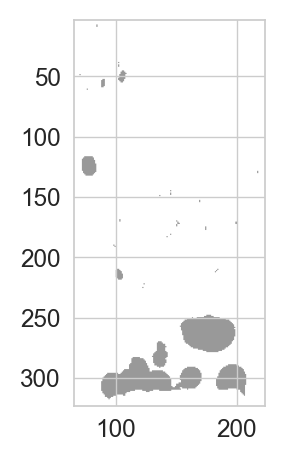

In [6]:
if COMPARE_WITH_TRACKPY:
    with nowarn(capture=True):
        from trackpy import batch, quiet

    quiet()

contours_df = get_contours_df(time)
composite_video = filled.max("frame").values
with bounded_ax(composite_video) as ax:
    ax.imshow(~composite_video, alpha=0.4)

HIDE

## Find size from filled contours using Trackpy

Use Trackpy to find bubble size given the filled contours.


In [7]:
if COMPARE_WITH_TRACKPY:
    tp_objects = (
        batch(frames=filled.values, diameter=GUESS_DIAMETER, characterize=True).assign(
            frame=lambda df: df.frame.replace(dict(enumerate(filled.frame.values)))
        )
    ).loc[:, TRACKPY_COLS]
else:
    tp_objects = DataFrame()

tp_objects

,y,x,frame,size
0,52.76,104.2,0,2.098
1,126.6,77.60,0,4.134
2,215.5,102.8,0,2.377
3,264.3,190.9,0,6.242
4,267.1,163.6,0,5.948
5,300.8,161.2,0,5.981
6,303.2,137.7,0,6.052
7,301.6,200.7,0,6.572
8,306.7,94.53,0,6.407
9,50.15,105.0,10,2.421


## Find size from contours

The prior approach throws out contour data, instead operating on filled contours. Instead, try using shapely to find size directly from contour data.

### Prepare to find objects

Prepare a dataframe with columns in a certain order, assign contour data to it, and demote the hiearchical indices to plain columns. Count the number of points in each contour and each frame, keeping only those which have enough points to describe a linear ring. Construct a GeoPandas geometry column and operate on it with Shapely to construct linear rings, returning centroids and the representative polygonal area. Also report the number of points in the loci of each contour per frame.


In [12]:
contours = (
    DataFrame(columns=["xpx", "ypx"])
    .assign(**contours_df.loc[IndexSlice[frames, :], :])
    .rename(axis="columns", mapper=dict(xpx="x", ypx="y"))
    .reset_index()
    .assign(
        count=lambda df: df.groupby(["frame", "contour"], **GBC).x.transform("count")
    )
    .query("count > 3")
    .assign(geometry=lambda df: points_from_xy(df.x, df.y))
    .groupby(["frame", "contour"], **GBC)
    .agg(
        count=NamedAgg(column="count", aggfunc="first"),
        centroid=NamedAgg(
            column="geometry", aggfunc=lambda df: LinearRing(df).centroid
        ),
        area=NamedAgg(column="geometry", aggfunc=lambda df: Polygon(df).area),
    )
    .assign(
        diameter_px=lambda df: sqrt(4 * df["area"] / pi),
        radius_of_gyration_px=lambda df: df["diameter_px"] / 4,
        size=lambda df: df["radius_of_gyration_px"],
    )
)
contours

,frame,contour,count,centroid,area,diameter_px,radius_of_gyration_px,size
0,0,0,29,POINT (158.849 302.154),220.5,16.76,4.189,4.189
1,0,1,33,POINT (196.526 301.300),396.5,22.47,5.617,5.617
2,0,2,77,POINT (115.762 303.327),943.5,34.66,8.665,8.665
3,0,3,18,POINT (135.982 286.103),69.00,9.373,2.343,2.343
4,0,4,56,POINT (177.224 264.401),837.0,32.65,8.161,8.161
5,0,6,8,POINT (102.753 215.500),20.00,5.046,1.262,1.262
6,0,18,16,POINT (77.554 126.554),99.00,11.23,2.807,2.807
7,0,19,5,POINT (88.768 58.000),3.000,1.954,0.4886,0.4886
8,0,20,7,POINT (104.232 52.768),13.00,4.068,1.017,1.017
9,10,0,34,POINT (196.347 301.781),380.5,22.01,5.503,5.503


Split the centroid point objects into separate named columns that conform to the Trackpy convention. Report the centroids in each frame.


In [13]:
outs = DfNbOuts(
    df=(
        GeoDataFrame(contours)
        .assign(x=lambda df: df.centroid.x, y=lambda df: df.centroid.y)
        .loc[:, COLS]
        .sort_values(["frame", "y", "x"], ignore_index=True)
    )
)
outs.df

,y,x,frame,size,area,diameter_px,radius_of_gyration_px
0,52.77,104.2,0,1.017,13.00,4.068,1.017
1,58.00,88.77,0,0.4886,3.000,1.954,0.4886
2,126.6,77.55,0,2.807,99.00,11.23,2.807
3,215.5,102.8,0,1.262,20.00,5.046,1.262
4,264.4,177.2,0,8.161,837.0,32.65,8.161
5,286.1,136.0,0,2.343,69.00,9.373,2.343
6,301.3,196.5,0,5.617,396.5,22.47,5.617
7,302.2,158.8,0,4.189,220.5,16.76,4.189
8,303.3,115.8,0,8.665,943.5,34.66,8.665
9,50.24,105.1,10,0.9974,12.50,3.989,0.9974


## Compare approaches

Compare Trackpy objects with contour objects. Here the guess radius for Trackpy object finding and contour perimeter filtering are matched to produce the same number of objects from each algorithm. Trackpy features more intelligent filtering, but takes much longer. Trackpy's approach for finding local maxima in grayscale images is applied even to binarized images, exhaustively searching for high points in the binary image, adding to execution time.

The percent difference between the approaches is relatively low for this subset, suggesting the contour centroid approach is reasonable.

A warm color palette is used to plot Trackpy objects, and a cool color palette is used to plot contour centroids.


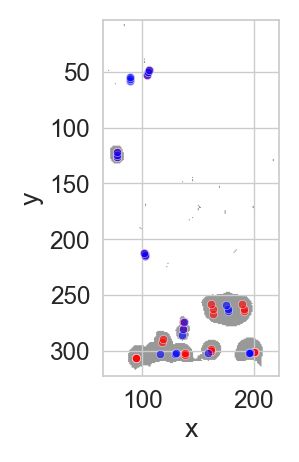

In [14]:
if COMPARE_WITH_TRACKPY:
    scatterplot(
        ax=ax, data=tp_objects, x="x", y="y", alpha=0.6, color="red", legend=False
    )
scatterplot(ax=ax, data=outs.df, x="x", y="y", alpha=0.6, color="blue", legend=False)

fig = ax.get_figure()
fig